In [1]:
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import cProfile
import emcee
import corner
import copy
# our own modules
import simplest_emulator
import linear_emulator
import gp_emulator
import data_PD2013
import mean_flux_model
import thermal_model
import pressure_model
import lya_theory
import likelihood
import emcee_sampler
import data_MPGADGET
import z_emulator
import p1d_arxiv

In [2]:
import matplotlib
font = {'size'   : 14}

matplotlib.rc('font', **font)

In [3]:
repo=os.environ['LYA_EMU_REPO']
skewers_label='Ns256_wM0.05'
#skewers_label=None
basedir="/p1d_emulator/sim_suites/emulator_256_28082019/"
#basedir=repo+"/p1d_emulator/sim_suites/emulator_256_15072019/"
p1d_label=None
undersample_z=1
paramList=["mF","sigT_Mpc","gamma","n_p","Delta2_p"]
max_arxiv_size=None
kmax_Mpc=8
z_list=None

In [4]:
set_k=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=4,pick_sim_number=0,
                            drop_temp_rescalings=True,skewers_label=skewers_label)
## Set up k bins for emulator call
k_test=set_k.data[1]["k_Mpc"][1:]
k_test=k_test[k_test<8]

In [5]:
## Now want to train an emulator on all 200 sims, and use those hyperparameters and
## param scalings to use 199 points and predict the 1 remaining
full_archive=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=4,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [6]:
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                                max_arxiv_size=max_arxiv_size,z_max=4,
                                verbose=False,paramList=paramList,train=True,set_noise_var=1e-3,
                                emu_type="k_bin",z_list=z_list,passArxiv=full_archive,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)

 /home/chris/.local/lib/python3.5/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 1600 points
Optimised


In [10]:
def return_crossvals(hyperparams):
    """ Pass a GP emulator, this will return arrays of the fractional
    true and theoretical error """
    
    if len(hyperparams)==3:
        rbf_only=True
    elif len(hyperparams)==4:
        rbf_only=False
    else:
        print("Wrong number of hyperparams:" , len(hyperparams))
    
    ## Data arrays
    fractional_error=np.empty((200,8,len(k_test)))
    theory_error=np.empty((200,8,len(k_test)))
    
    iterable_archive=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=4,
                            drop_temp_rescalings=True,skewers_label=skewers_label)


    for simnum in range(0,200):
        truth=p1d_arxiv.ArxivP1D(basedir=basedir,
                                drop_tau_rescalings=True,z_max=4,pick_sim_number=simnum,
                                drop_temp_rescalings=True,skewers_label=skewers_label)
        
        ## Temporarily remove the first 8 items, corresponding to this sim
        temp_list=[]
        for aa in range(0,8):
            temp_list.append(iterable_archive.data.pop(0))
                            
        
        emu_test=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                                max_arxiv_size=max_arxiv_size,z_max=4,
                                verbose=False,paramList=paramList,train=False,
                                emu_type="k_bin",z_list=z_list,passArxiv=iterable_archive,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True,rbf_only=rbf_only)
        emu_test.load_hyperparams(hyperparams)
        emu_test.crossval=True
        
        
        for aa,item in enumerate(truth.data):
            emu_call={}
            for bb,param in enumerate(paramList):
                emu_call[param]=item[param]

            pred,err=emu_test.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])

            fractional_error[simnum,aa,:]=pred/item["p1d_Mpc"][1:(len(k_test)+1)]
            theory_error[simnum,aa,:]=(pred+np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)]
                             
        ## Now rebuild the archive, put the old sim at the end
        for item in temp_list:
            iterable_archive.data.append(item)
            
    return np.mean(fractional_error,axis=0),np.std(fractional_error,axis=0),np.mean(theory_error,axis=0),np.std(theory_error,axis=0)

In [11]:
def return_crossvals_z():
    """ Cross validation for z and k for a redshift-split
    emulator """
    
    ## Data arrays
    fractional_error=np.empty((200,8,len(k_test)))
    theory_error=np.empty((200,8,len(k_test)))
    
    iterable_archive=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=4,
                            drop_temp_rescalings=True,skewers_label=skewers_label)


    for simnum in range(0,200):
        truth=p1d_arxiv.ArxivP1D(basedir=basedir,
                                drop_tau_rescalings=True,z_max=4,pick_sim_number=simnum,
                                drop_temp_rescalings=True,skewers_label=skewers_label)
        
        ## Temporarily remove the first 8 items, corresponding to this sim
        temp_list=[]
        for aa in range(0,8):
            temp_list.append(iterable_archive.data.pop(0))
                            
        
        emu_test=z_emulator.ZEmulator(basedir,p1d_label,skewers_label,
                                max_arxiv_size=max_arxiv_size,z_max=4,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin",z_list=z_list,passArxiv=iterable_archive,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)
        
        
        for aa,item in enumerate(truth.data):
            emu_call={}
            for bb,param in enumerate(paramList):
                emu_call[param]=item[param]

            pred,err=emu_test.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])

            fractional_error[simnum,aa,:]=pred/item["p1d_Mpc"][1:(len(k_test)+1)]
            theory_error[simnum,aa,:]=(pred+np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)]
                             
        ## Now rebuild the archive, put the old sim at the end
        for item in temp_list:
            iterable_archive.data.append(item)
            
    return np.mean(fractional_error,axis=0),np.std(fractional_error,axis=0),np.mean(theory_error,axis=0),np.std(theory_error,axis=0)

In [12]:
mean_fractional,std_fractional,mean_theory,std_theory=return_crossvals(emu.gp.param_array)

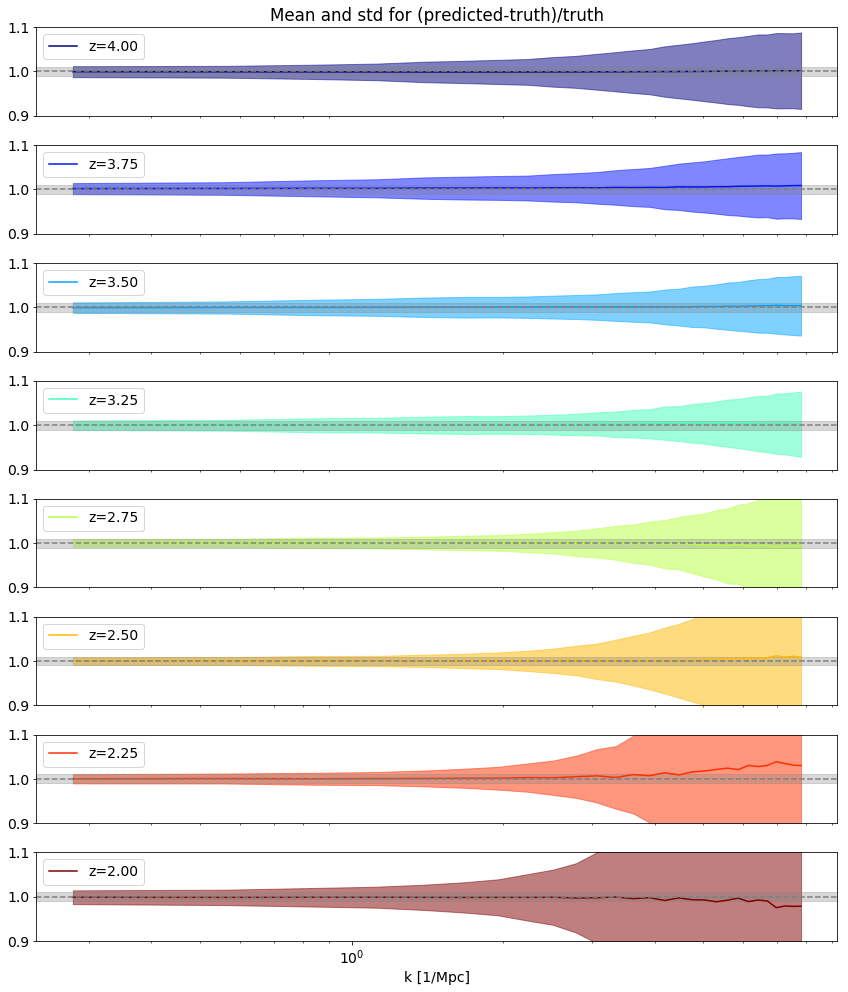

In [13]:
plt.figure(figsize=[12,14])
dex=0
for aa in range(0,8):
    plt.subplot(8,1,aa+1)
    if aa==0:
        plt.title("Mean and std for (predicted-truth)/truth")
    col = plt.cm.jet(dex/(len(set_k.data)-1))
    dex+=1
    plt.plot(k_test,mean_fractional[aa,:],color=col,label="z=%.2f" % set_k.data[aa]["z"])
    plt.axhspan(0.99,1.01,color="gray",alpha=0.3)
    plt.axhline(1,linestyle="dashed",color="gray")
    plt.fill_between(k_test,mean_fractional[aa,:]+std_fractional[aa,:],
            mean_fractional[aa,:]-std_fractional[aa,:],alpha=0.5,color=col)
    plt.ylim(0.9,1.1)
    plt.legend(loc="upper left")
    plt.xscale("log")
    if aa != 7:
        plt.xticks([])
plt.xlabel("k [1/Mpc]")
plt.tight_layout()
plt.savefig("/home/chris/Testbed/EmuScripts/CrossvalPlots/single_emu_true_error.pdf")

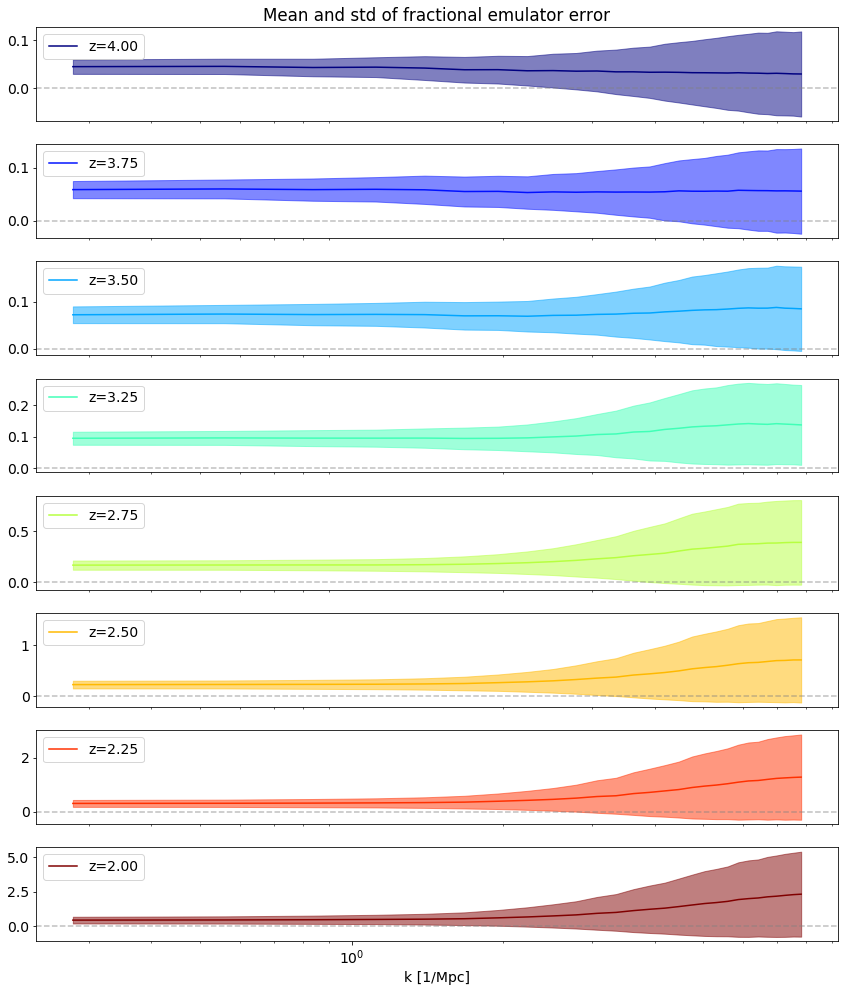

In [14]:
plt.figure(figsize=[12,14])
dex=0
for aa in range(0,8):
    plt.subplot(8,1,aa+1)
    if aa==0:
        plt.title("Mean and std of fractional emulator error")
    col = plt.cm.jet(dex/(len(set_k.data)-1))
    dex+=1
    plt.axhline(0,linestyle="dashed",color="gray",alpha=0.5)
    plt.plot(k_test,mean_theory[aa,:]-1,color=col,label="z=%.2f" % set_k.data[aa]["z"])
    plt.fill_between(k_test,mean_theory[aa,:]+std_theory[aa,:]-1,
            mean_theory[aa,:]-std_theory[aa,:]-1,alpha=0.5,color=col)
    #plt.ylim(0.95,1.05)
    plt.legend(loc="upper left")
    #plt.ylim(-0.05,2)
    plt.xscale("log")
    #plt.yscale("log")
    if aa != 7:
        plt.xticks([])
plt.xlabel("k [1/Mpc]")
plt.tight_layout()
plt.savefig("/home/chris/Testbed/EmuScripts/CrossvalPlots/single_emu_theory_error.pdf")


In [15]:
## Change noise_var
emu_noisy=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                                max_arxiv_size=max_arxiv_size,z_max=4,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin",z_list=z_list,passArxiv=full_archive,
                                drop_tau_rescalings=True,set_noise_var=1e-10,
                                drop_temp_rescalings=True)
## Add postprocessing rescalings

## Undersample z

## Change hyperparams as you move through paramspace

Training GP on 1600 points
Optimised


In [16]:
mean_fractional_noisy,std_fractional_noisy,mean_theory_noisy,std_theory_noisy=return_crossvals(emu_noisy.gp.param_array)

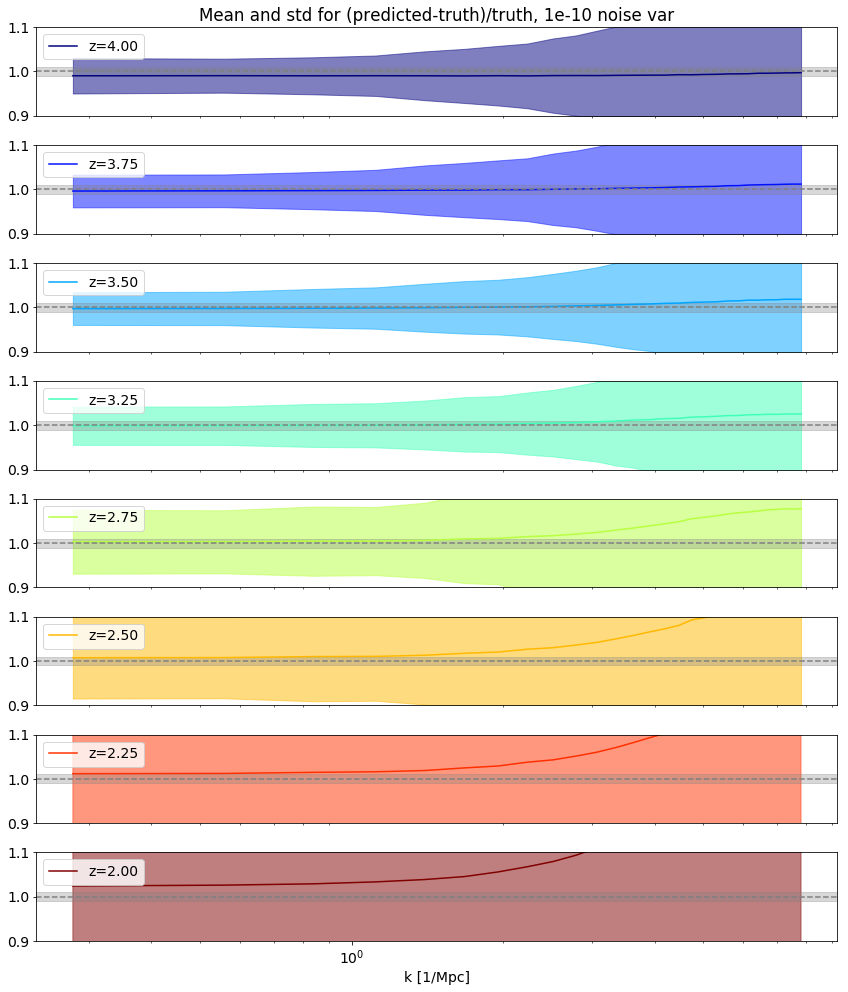

In [17]:
plt.figure(figsize=[12,14])
dex=0
for aa in range(0,8):
    plt.subplot(8,1,aa+1)
    if aa==0:
        plt.title("Mean and std for (predicted-truth)/truth, 1e-10 noise var")
    col = plt.cm.jet(dex/(len(set_k.data)-1))
    dex+=1
    plt.plot(k_test,mean_fractional_noisy[aa,:],color=col,label="z=%.2f" % set_k.data[aa]["z"])
    plt.axhspan(0.99,1.01,color="gray",alpha=0.3)
    plt.axhline(1,linestyle="dashed",color="gray")
    plt.fill_between(k_test,mean_fractional_noisy[aa,:]+std_fractional_noisy[aa,:],
            mean_fractional_noisy[aa,:]-std_fractional_noisy[aa,:],alpha=0.5,color=col)
    plt.ylim(0.9,1.1)
    plt.legend(loc="upper left")
    plt.xscale("log")
    if aa != 7:
        plt.xticks([])
plt.xlabel("k [1/Mpc]")
plt.tight_layout()
plt.savefig("/home/chris/Testbed/EmuScripts/CrossvalPlots/single_emu_lownoise_true_error.pdf")

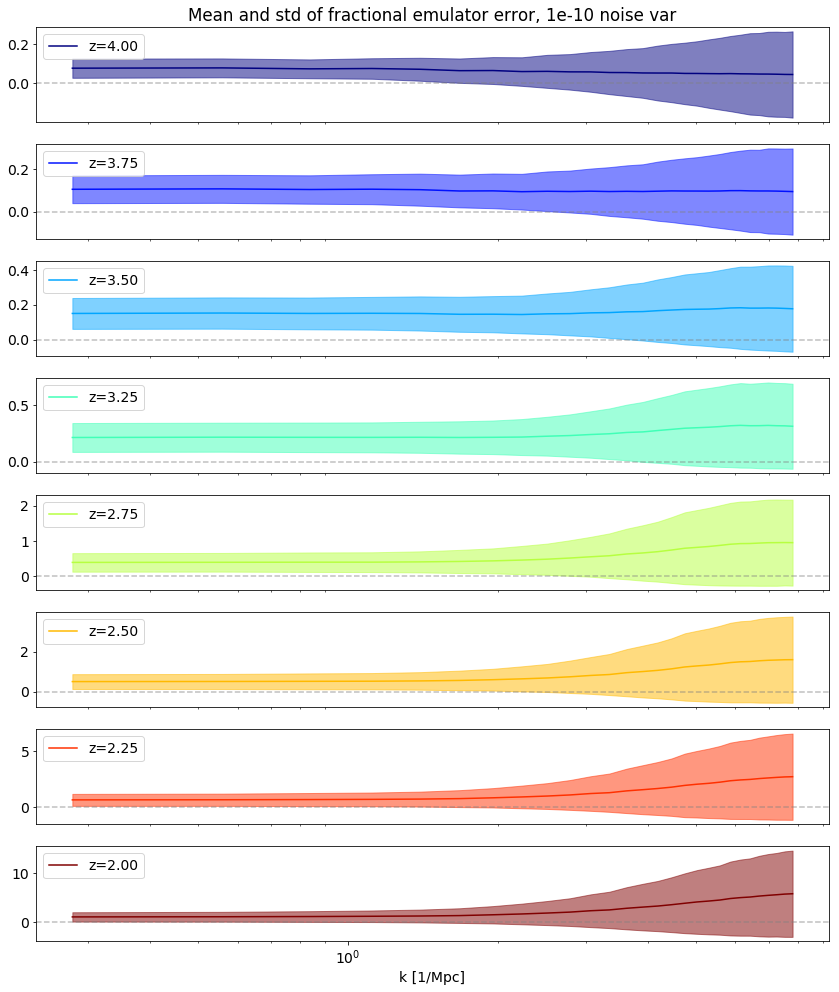

In [18]:
plt.figure(figsize=[12,14])
dex=0
for aa in range(0,8):
    plt.subplot(8,1,aa+1)
    if aa==0:
        plt.title("Mean and std of fractional emulator error, 1e-10 noise var")
    col = plt.cm.jet(dex/(len(set_k.data)-1))
    dex+=1
    plt.axhline(0,linestyle="dashed",color="gray",alpha=0.5)
    plt.plot(k_test,mean_theory_noisy[aa,:]-1,color=col,label="z=%.2f" % set_k.data[aa]["z"])
    plt.fill_between(k_test,mean_theory_noisy[aa,:]+std_theory_noisy[aa,:]-1,
            mean_theory_noisy[aa,:]-std_theory_noisy[aa,:]-1,alpha=0.5,color=col)
    #plt.ylim(0.95,1.05)
    plt.legend(loc="upper left")
    #plt.ylim(-0.05,2)
    plt.xscale("log")
    #plt.yscale("log")
    if aa != 7:
        plt.xticks([])
plt.xlabel("k [1/Mpc]")
plt.tight_layout()
plt.savefig("/home/chris/Testbed/EmuScripts/CrossvalPlots/single_emu_lownoise_theory_error.pdf")

In [19]:
mean_fractional_z,std_fractional_z,mean_theory_z,std_theory_z=return_crossvals_z()
%%capture

Loading emulator using a specific arxiv, not the one set in basedir
Training GP on 199 points
Optimised
Training GP on 199 points
Optimised
Training GP on 199 points
Optimised
Training GP on 199 points
Optimised
Training GP on 199 points
Optimised
Training GP on 199 points
Optimised
Training GP on 199 points
Optimised
Training GP on 199 points
Optimised
Loading emulator using a specific arxiv, not the one set in basedir
Training GP on 199 points
Optimised
Training GP on 199 points
Optimised
Training GP on 199 points
Optimised
Training GP on 199 points
Optimised
Training GP on 199 points
Optimised
Training GP on 199 points
Optimised
Training GP on 199 points
Optimised
Training GP on 199 points
Optimised
Loading emulator using a specific arxiv, not the one set in basedir
Training GP on 199 points
Optimised
Training GP on 199 points
Optimised
Training GP on 199 points
Optimised
Training GP on 199 points
Optimised
Training GP on 199 points
Optimised
Training GP on 199 points
Optimised
Trai

 /home/chris/.local/lib/python3.5/site-packages/GPy/kern/src/rbf.py:51: RuntimeWarning:overflow encountered in square


Optimised
Loading emulator using a specific arxiv, not the one set in basedir
Training GP on 199 points
Optimised
Training GP on 199 points
Optimised
Training GP on 199 points
Optimised
Training GP on 199 points
Optimised
Training GP on 199 points
Optimised
Training GP on 199 points
Optimised
Training GP on 199 points
Optimised
Training GP on 199 points
Optimised
Loading emulator using a specific arxiv, not the one set in basedir
Training GP on 199 points
Optimised
Training GP on 199 points
Optimised
Training GP on 199 points
Optimised
Training GP on 199 points
Optimised
Training GP on 199 points
Optimised
Training GP on 199 points
Optimised
Training GP on 199 points
Optimised
Training GP on 199 points
Optimised
Loading emulator using a specific arxiv, not the one set in basedir
Training GP on 199 points
Optimised
Training GP on 199 points
Optimised
Training GP on 199 points
Optimised
Training GP on 199 points
Optimised
Training GP on 199 points
Optimised
Training GP on 199 points
Opti

UsageError: Line magic function `%%capture` not found.


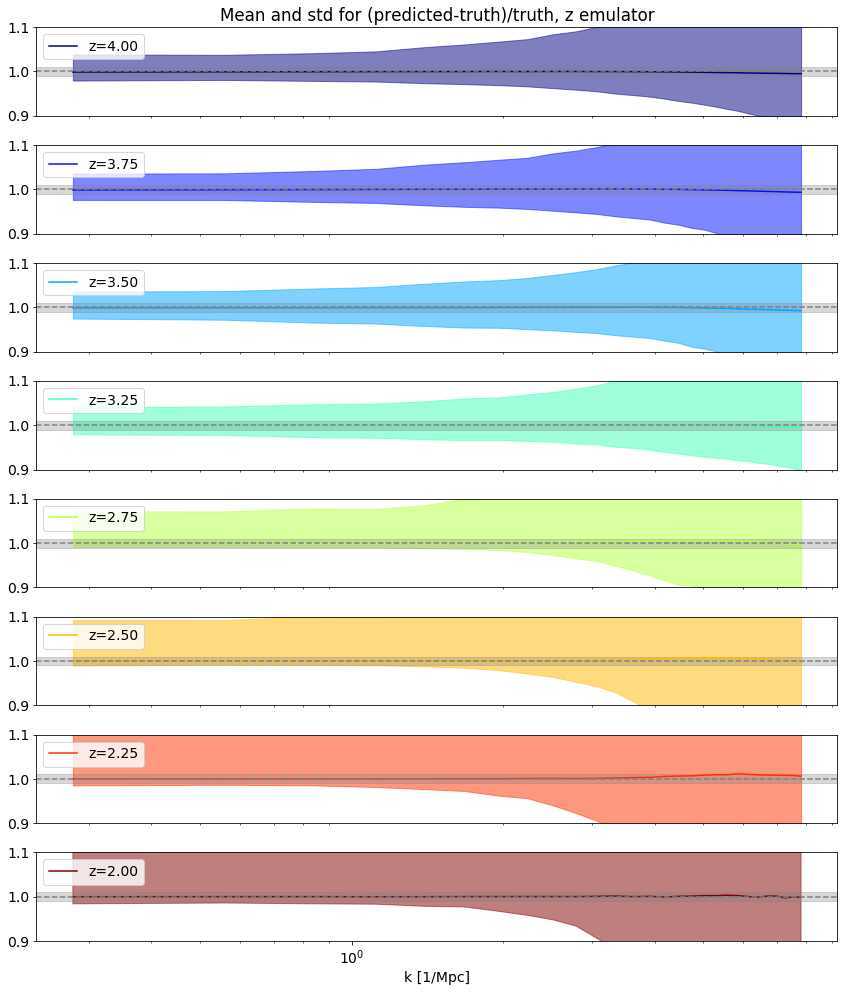

In [20]:
plt.figure(figsize=[12,14])
dex=0
for aa in range(0,8):
    plt.subplot(8,1,aa+1)
    if aa==0:
        plt.title("Mean and std for (predicted-truth)/truth, z emulator")
    col = plt.cm.jet(dex/(len(set_k.data)-1))
    dex+=1
    plt.plot(k_test,mean_fractional_z[aa,:],color=col,label="z=%.2f" % set_k.data[aa]["z"])
    plt.axhspan(0.99,1.01,color="gray",alpha=0.3)
    plt.axhline(1,linestyle="dashed",color="gray")
    plt.fill_between(k_test,mean_fractional_z[aa,:]+std_fractional_noisy[aa,:],
            mean_fractional_z[aa,:]-std_fractional_z[aa,:],alpha=0.5,color=col)
    plt.ylim(0.9,1.1)
    plt.legend(loc="upper left")
    plt.xscale("log")
    if aa != 7:
        plt.xticks([])
plt.xlabel("k [1/Mpc]")
plt.tight_layout()
plt.savefig("/home/chris/Testbed/EmuScripts/CrossvalPlots/z_emu_true_error.pdf")

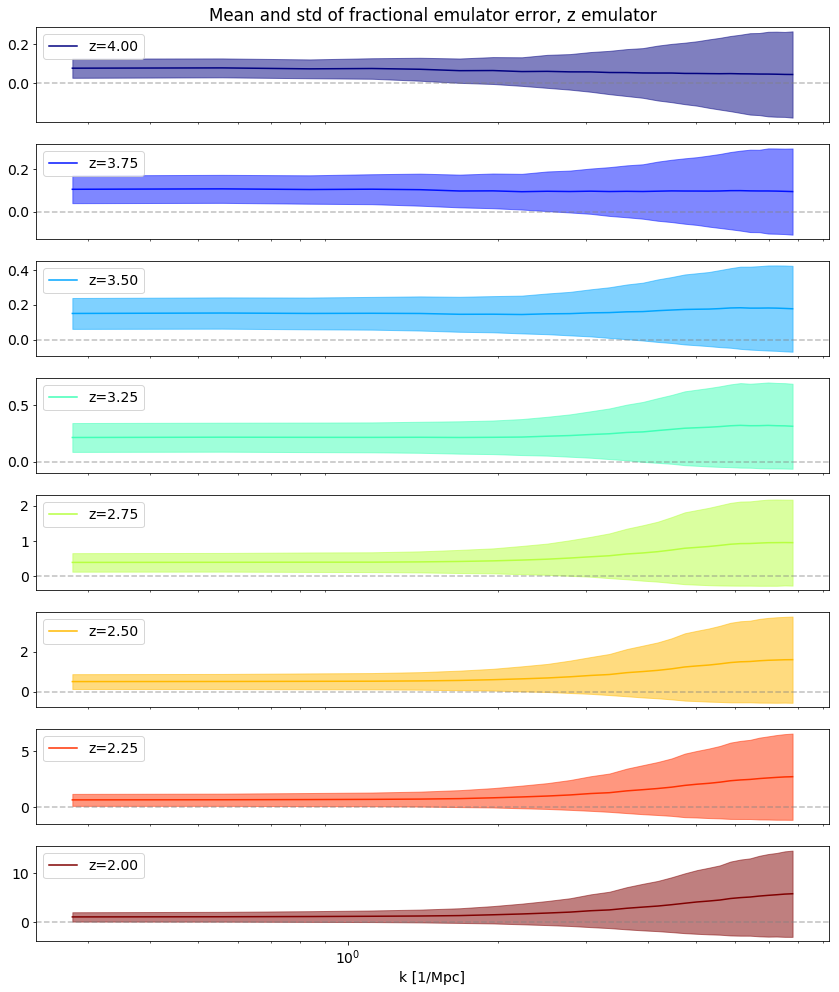

In [21]:
plt.figure(figsize=[12,14])
dex=0
for aa in range(0,8):
    plt.subplot(8,1,aa+1)
    if aa==0:
        plt.title("Mean and std of fractional emulator error, z emulator")
    col = plt.cm.jet(dex/(len(set_k.data)-1))
    dex+=1
    plt.axhline(0,linestyle="dashed",color="gray",alpha=0.5)
    plt.plot(k_test,mean_theory_noisy[aa,:]-1,color=col,label="z=%.2f" % set_k.data[aa]["z"])
    plt.fill_between(k_test,mean_theory_noisy[aa,:]+std_theory_noisy[aa,:]-1,
            mean_theory_noisy[aa,:]-std_theory_noisy[aa,:]-1,alpha=0.5,color=col)
    #plt.ylim(0.95,1.05)
    plt.legend(loc="upper left")
    #plt.ylim(-0.05,2)
    plt.xscale("log")
    #plt.yscale("log")
    if aa != 7:
        plt.xticks([])
plt.xlabel("k [1/Mpc]")
plt.tight_layout()
plt.savefig("/home/chris/Testbed/EmuScripts/CrossvalPlots/z_emu_theory_error.pdf")

In [22]:
## Now check with only the RBF kernel
emu_rbf=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                                max_arxiv_size=max_arxiv_size,z_max=4,
                                verbose=False,paramList=paramList,train=True,set_noise_var=1e-3,
                                emu_type="k_bin",z_list=z_list,passArxiv=full_archive,rbf_only=True,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)

Training GP on 1600 points
Optimised


In [24]:
mean_fractional_rbf,std_fractional_rbf,mean_theory_rbf,std_theory_rbf=return_crossvals(emu_rbf.gp.param_array)

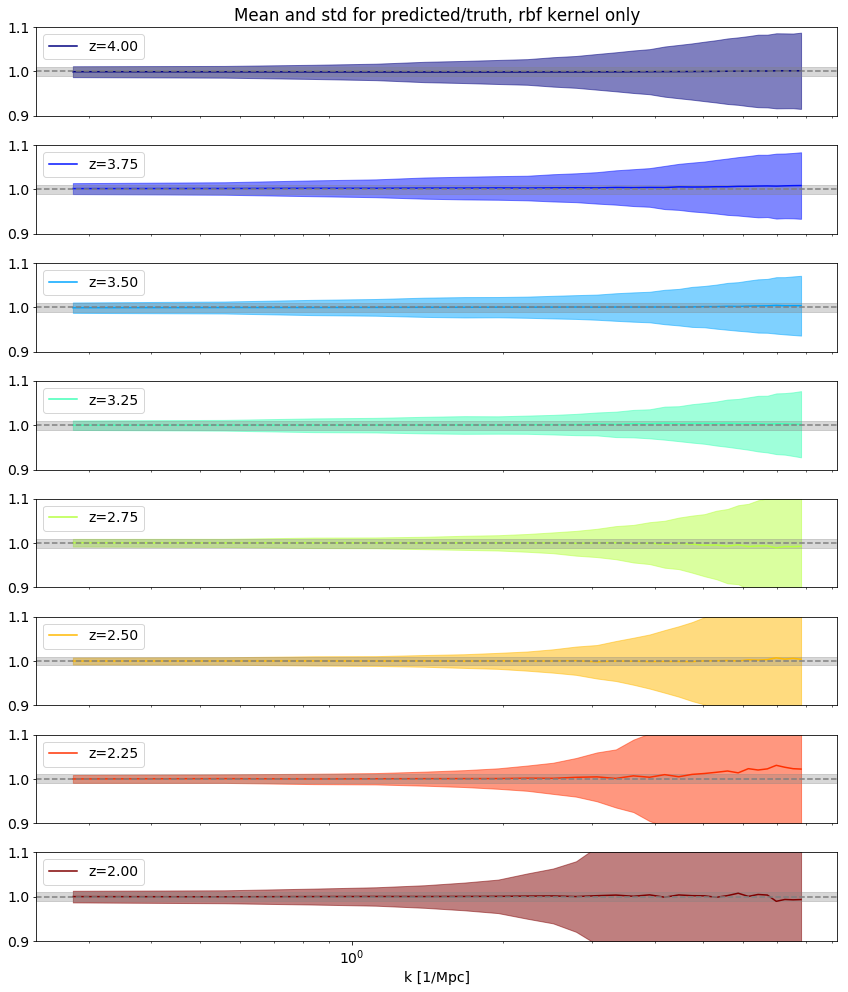

In [25]:
plt.figure(figsize=[12,14])
dex=0
for aa in range(0,8):
    plt.subplot(8,1,aa+1)
    if aa==0:
        plt.title("Mean and std for predicted/truth, rbf kernel only")
    col = plt.cm.jet(dex/(len(set_k.data)-1))
    dex+=1
    plt.plot(k_test,mean_fractional_rbf[aa,:],color=col,label="z=%.2f" % set_k.data[aa]["z"])
    plt.axhspan(0.99,1.01,color="gray",alpha=0.3)
    plt.axhline(1,linestyle="dashed",color="gray")
    plt.fill_between(k_test,mean_fractional_rbf[aa,:]+std_fractional_rbf[aa,:],
            mean_fractional_rbf[aa,:]-std_fractional_rbf[aa,:],alpha=0.5,color=col)
    plt.ylim(0.9,1.1)
    plt.legend(loc="upper left")
    plt.xscale("log")
    if aa != 7:
        plt.xticks([])
plt.xlabel("k [1/Mpc]")
plt.tight_layout()
plt.savefig("/home/chris/Testbed/EmuScripts/CrossvalPlots/single_emu_true_error_rbf.pdf")

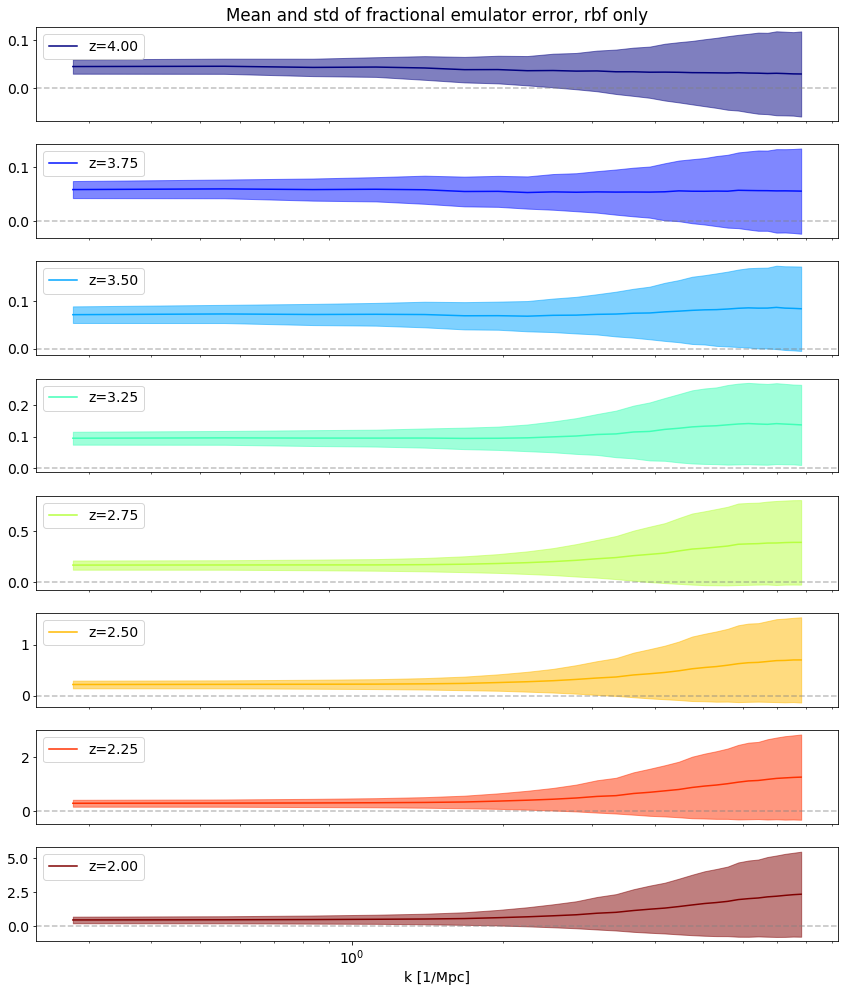

In [26]:
plt.figure(figsize=[12,14])
dex=0
for aa in range(0,8):
    plt.subplot(8,1,aa+1)
    if aa==0:
        plt.title("Mean and std of fractional emulator error, rbf only")
    col = plt.cm.jet(dex/(len(set_k.data)-1))
    dex+=1
    plt.axhline(0,linestyle="dashed",color="gray",alpha=0.5)
    plt.plot(k_test,mean_theory_rbf[aa,:]-1,color=col,label="z=%.2f" % set_k.data[aa]["z"])
    plt.fill_between(k_test,mean_theory_rbf[aa,:]+std_theory_rbf[aa,:]-1,
            mean_theory_rbf[aa,:]-std_theory_rbf[aa,:]-1,alpha=0.5,color=col)
    #plt.ylim(0.95,1.05)
    plt.legend(loc="upper left")
    #plt.ylim(-0.05,2)
    plt.xscale("log")
    #plt.yscale("log")
    if aa != 7:
        plt.xticks([])
plt.xlabel("k [1/Mpc]")
plt.tight_layout()
plt.savefig("/home/chris/Testbed/EmuScripts/CrossvalPlots/single_emu_theory_error_rbf.pdf")

In [ ]:
test_sim_num=np.random.randint(199)
print(test_sim_num)
test_sim_archive=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=4,pick_sim_number=test_sim_num,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

for item in test_sim_archive.data:
    test_model={}
    for param in paramList:
        test_model[param]=item[param]
    pred,err=emu_noisy.emulate_p1d_Mpc(test_model,k_test,True,item["z"])

In [ ]:
reduced_arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=4,drop_sim_number=test_sim_num,
                            drop_temp_rescalings=True,skewers_label=skewers_label)
## Change noise_var
emu_no_noise_reduced=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                                max_arxiv_size=max_arxiv_size,z_max=4,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin",z_list=z_list,passArxiv=reduced_arxiv,
                                drop_tau_rescalings=True,set_noise_var=1e-10,
                                drop_temp_rescalings=True)
emu_no_noise_reduced.crossval=True
for item in test_sim_archive.data:
    test_model={}
    for param in paramList:
        test_model[param]=item[param]
    pred,err=emu_no_noise_reduced.emulate_p1d_Mpc(test_model,k_test,True,item["z"])

In [ ]:
u2_archive=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=4,undersample_cube=2,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [ ]:
emu_u2=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,
                                max_arxiv_size=max_arxiv_size,z_max=4,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin",z_list=z_list,passArxiv=u2_archive,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)

In [ ]:
mean_fractional_u2,std_fractional_u2,mean_theory_u2,std_theory_u2=return_crossvals(emu_u2)

In [ ]:
plt.figure(figsize=[12,14])
dex=0
for aa in range(0,8):
    plt.subplot(8,1,aa+1)
    if aa==0:
        plt.title("Mean and std for (predicted-truth)/truth, 1e-10 noise var, 100 sims")
    col = plt.cm.jet(dex/(len(truth.data)-1))
    dex+=1
    plt.plot(k_test,mean_fractional_noisy[aa,:],color=col,label="z=%.2f" % truth.data[aa]["z"])
    #plt.axhspan(0.99,1.01,color="gray",alpha=0.3)
    plt.axhline(1,linestyle="dashed",color="gray")
    plt.fill_between(k_test,mean_fractional_noisy[aa,:]+std_fractional_noisy[aa,:],
            mean_fractional_noisy[aa,:]-std_fractional_noisy[aa,:],alpha=0.5,color=col)
    #plt.ylim(0.95,1.05)
    plt.legend(loc="upper left")
    plt.xscale("log")
    if aa != 7:
        plt.xticks([])
plt.xlabel("k [1/Mpc]")
plt.tight_layout()